In [1]:
import os
path = r"C:/Users/ky090/OneDrive - The University of Texas at Austin/001_Market/005_Python"
path = path.replace("\\", "/")
os.chdir(path)
# https://smart-hint.com/python/style/
# https://www.salesanalytics.co.jp/datascience/datascience046/

%matplotlib inline
%run -m Market_Data

## The following code is the same code as in Market_Data.py

In [2]:
import pdblp
from xbbg import blp
import workdays
import time
import datetime
import pandas as pd
import numpy as np
from datetime import datetime, timedelta, date
from dateutil.relativedelta import relativedelta
import calendar
import base64
import matplotlib.pyplot as plt
import os
import webbrowser
pd.set_option('display.max_columns', 70)

path = r"C:\Users\ky090\OneDrive - The University of Texas at Austin\001_Market\100_Output"
path = path.replace("\\", "/")
os.chdir(path)

ODA = workdays.workday(date.today(), days=-1) #One day agp
TDA= workdays.workday(date.today(), days=-2)  #Two days ago
OYA = TDA - relativedelta(months=13)
OYA = OYA.replace(day=calendar.monthrange(OYA.year, OYA.month)[1]) #One year ago
YE = date(TDA.year, 3, 31) if TDA.month > 3 or (TDA.month == 3 and TDA.day == 31) else date(TDA.year - 1, 3, 31)
# ME = (date(TDA.year, TDA.month, 1) + relativedelta(months=-1, day=31)) #Month End
ME = date(TDA.year, TDA.month, 1) + relativedelta(months=0, day=1)
ME = workdays.workday(ME, days=-1)

In [3]:
html = "<h3><u>Market Data as of " +ODA.strftime("%Y%m%d") + "</u></h3>"
def f(df,YK,field,html,flag=0,NC=0,diff=0):
    df = pd.DataFrame.from_dict(df, orient='index').reset_index(drop=False)
    df.columns = ["Ticker","Name"]

    if flag ==1:
        T = df.Ticker + "A Index"
        BDP = blp.bdp(tickers=T, flds=["country_iso","exch_code","crncy","undl_spot_ticker"]).loc[T,:]

        T = list(dict.fromkeys(BDP.undl_spot_ticker))
        T1 = pd.Series(T) + " Index"
        BDP1 = blp.bdp(tickers=T1, flds=["country_iso","crncy","security_name","name"]).loc[T1,:].reset_index()
        BDP1["index"] = T

        df["Crncy"] = BDP.crncy.tolist()
        df["Undl"] = BDP.undl_spot_ticker.tolist()
        df.insert(0, "Country", 0)
        df["Country"] = BDP1.set_index("index").loc[df["Undl"],"country_iso"].values
        
    if flag ==2:
        T = df.Ticker + "A Comdty"
        BDP = blp.bdp(tickers=T, flds=["fut_ctd_isin","mty_years","crncy"]).loc[T,:]
        df["Year"] = (BDP.mty_years.apply("{:,.1f}".format)).tolist()
        
        df.insert(0, "Country", 0)
        df["Country"] = [i[:2] for i in BDP.fut_ctd_isin]
    
    
    T = df.Ticker.tolist()
    T1 = (pd.Series(T) + YK).tolist()
    BDH = blp.bdh(T1, field, OYA, ODA, Calendar="5D", Fill="P").reset_index()
    BDH = BDH[["index"]+T1]    
    BDH.columns = ["Date"] + T
    BDH["Date"] = pd.to_datetime(BDH["Date"])
    
    if flag ==1:
        df = df.drop("Undl", axis=1)
        
    if flag >= 1:
        df["Country"] = df["Country"].where(df["Country"].shift() != df["Country"], "")
        
    if len(df) == len(df[df.Name==""]):
        df = df.drop("Name", axis=1)


    C = {"TDA":TDA,"ME":ME,"YE":YE}
    tmp = BDH.loc[len(BDH)-1, T]
    for i in C:
        if diff == 1:
            df[i] = (tmp - BDH.loc[BDH["Date"]==C[i].strftime("%Y%m%d"), T]).values[0]  
        else:
            df[i] = (tmp / BDH.loc[BDH["Date"]==C[i].strftime("%Y%m%d"), T] - 1).values[0]
        
    C = ["1D"] + [ME.strftime("%Y/%m/%d")[5:7].replace('0', '') + ME.strftime("%Y/%m/%d")[7:]] + [YE.strftime("%Y/%m/%d")[5:7].replace('0', '') + YE.strftime("%Y/%m/%d")[7:]]
    
    df.columns = df.columns[:df.shape[1]-3].tolist() + C

    if diff == 1:
        html += df.style\
            .bar(subset=C, align='mid', color=["pink", "lightblue"])\
            .format({c: '{:.2f}' for c in C})\
            .render()
    else:        
        html += df.style\
            .bar(subset=C, align='mid', color=["pink", "lightblue"])\
            .format({c: '{:.2%}' for c in C})\
            .render()

    if NC == 0:
        tmp = len(T) // 2 + len(T) % 2
        fig, ax = plt.subplots(tmp, 2,figsize=(10,tmp*2),tight_layout=True)
        for i in range(len(T)):
            ax[i//2,i%2].plot(BDH["Date"], BDH[T[i]])
            ax[i//2,i%2].set_title(T[i])

        plt.savefig("tmp.png")

        with open("tmp.png", "rb") as image_file:
            encoded_string = base64.b64encode(image_file.read()).decode()
        html += f'<img src="data:image/png;base64,{encoded_string}" width="850">'
        os.remove("tmp.png")

    html += "<h6>_________________________________________________________________________________________________________________________</h6>"
    
    
    if diff == 1:
        display(df.style\
                .bar(subset=C, align='mid', color=["pink", "lightblue"])\
                .format({c: '{:.2f}' for c in C})\
               )
    else:
        display(df.style\
                .bar(subset=C, align='mid', color=["pink", "lightblue"])\
                .format({c: '{:.2%}' for c in C})\
               )    

    if NC == 0:
        plt.show()
    
    return html

C:\Users\A1800401\AppData\Local\Temp\ipykernel_89736\1202258146.py:67: FutureWarning: this method is deprecated in favour of `Styler.to_html()`
  .render()


,Country,Ticker,Name,Crncy,1D,9/29,3/31
0,US,DM,Dow,USD,0.40%,0.63%,-0.38%
1,,ES,S&P500,USD,0.52%,1.53%,3.91%
2,,NQ,Nasdaq,USD,0.55%,2.72%,11.97%
3,,RTY,Russ2000(Small),USD,1.11%,-0.48%,-3.21%
4,EU,VG,EuroStox,EUR,2.30%,0.55%,-2.09%
5,DE,GX,Dax,EUR,1.94%,0.06%,-3.47%
6,FR,CF,CAC,EUR,2.01%,0.29%,-2.63%
7,GB,Z,FTSE100,GBP,1.93%,0.02%,-0.52%
8,CH,SM,,CHF,1.75%,0.39%,-0.31%
9,CA,PT,,CAD,1.44%,-0.24%,-3.58%


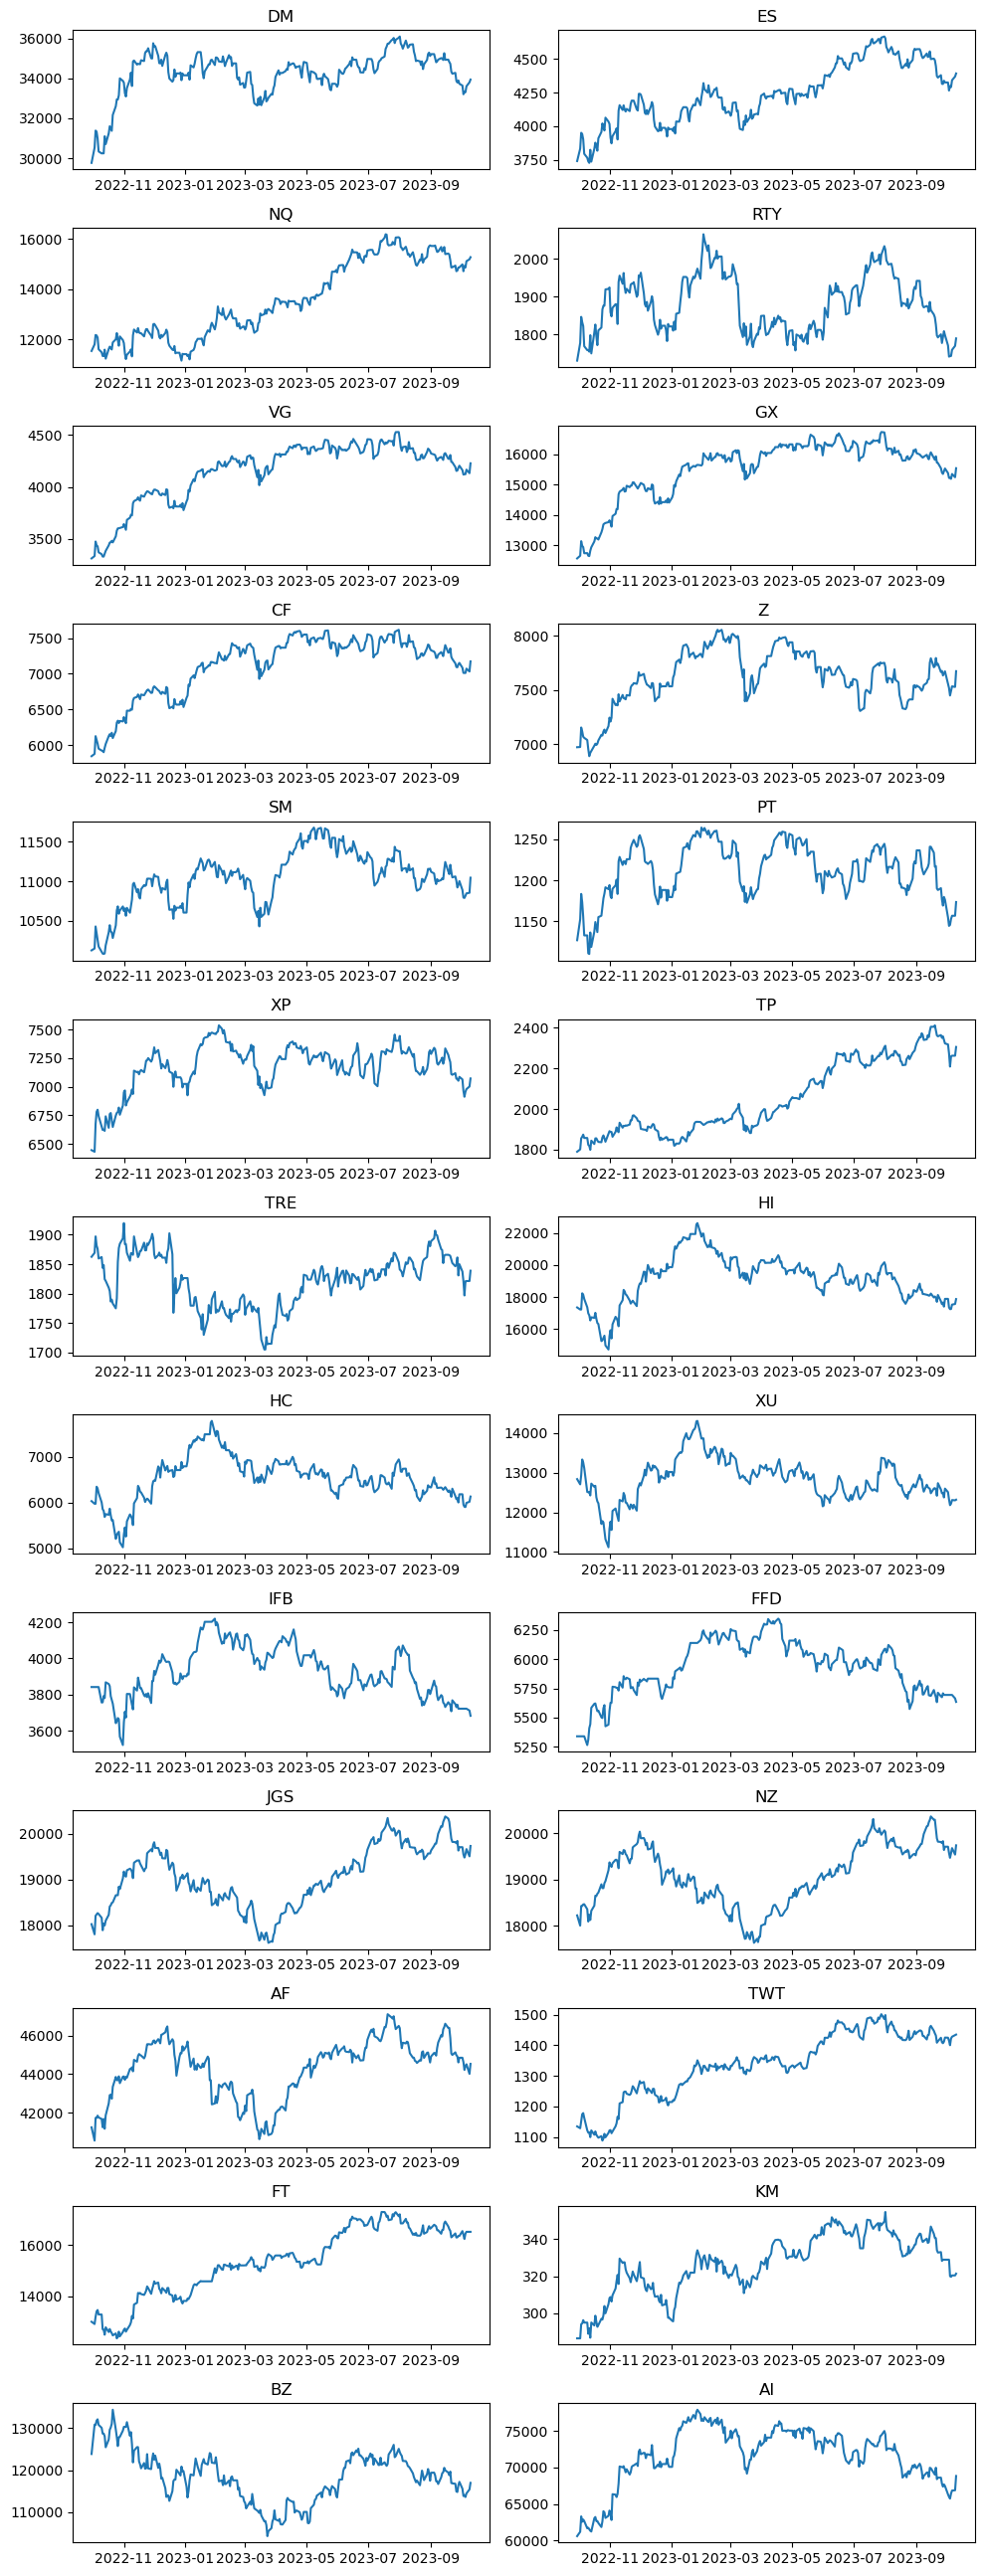

In [4]:
df = {
    'DM': ['Dow'],
    'ES': ['S&P500'],
    'NQ': ['Nasdaq'],
    'RTY': ['Russ2000(Small)'],
    'VG': ['EuroStox'],
    'GX': ['Dax'],
    'CF': ['CAC'],
    'Z ': ['FTSE100'],
    'SM': [''],
    'PT': [''],
    'XP': [''],
    'TP': ['Topix'],
    'TRE': ['Reit'],
    'HI': ['HangSeng'],
    'HC': ['Enterprises'],
    'XU': ['CHINA A50(SG)'],
    'IFB': ['CSI300(Large)'],
    'FFD': ['CSI500(Small)'],
    'JGS': ['Nifty50(SG)'],
    'NZ': ['Nifty50'],
    'AF': ['NiftyBank'],
    'TWT': ['FTSE_Taiwan(SG)'],
    'FT': ['TAIEX'],
    'KM': [''],
    'BZ': [''],
    'AI': ['']
}

html = f(df,"1 index","px_last",html,1)

C:\Users\A1800401\AppData\Local\Temp\ipykernel_89736\1202258146.py:67: FutureWarning: this method is deprecated in favour of `Styler.to_html()`
  .render()


,Ticker,Name,1D,9/29,3/31
0,S5CONS,Cons_Staple,1.08%,-2.00%,-7.43%
1,S5ENRS,Energy,-0.02%,-2.06%,8.93%
2,S5FINL,Financials,0.77%,0.39%,4.55%
3,S5HLTH,Health_Care,0.49%,1.83%,2.06%
4,S5INDU,Industrials,0.57%,1.60%,2.61%
5,S5INFT,Information,0.15%,3.57%,14.54%
6,S5MATR,Materials,1.08%,0.48%,-1.14%
7,S5TELS,COMM_SVC,0.22%,4.45%,21.72%
8,S5UTIL,Utilities,1.36%,-0.59%,-12.07%
9,S5COND,Cons_Discret,1.09%,1.01%,10.18%


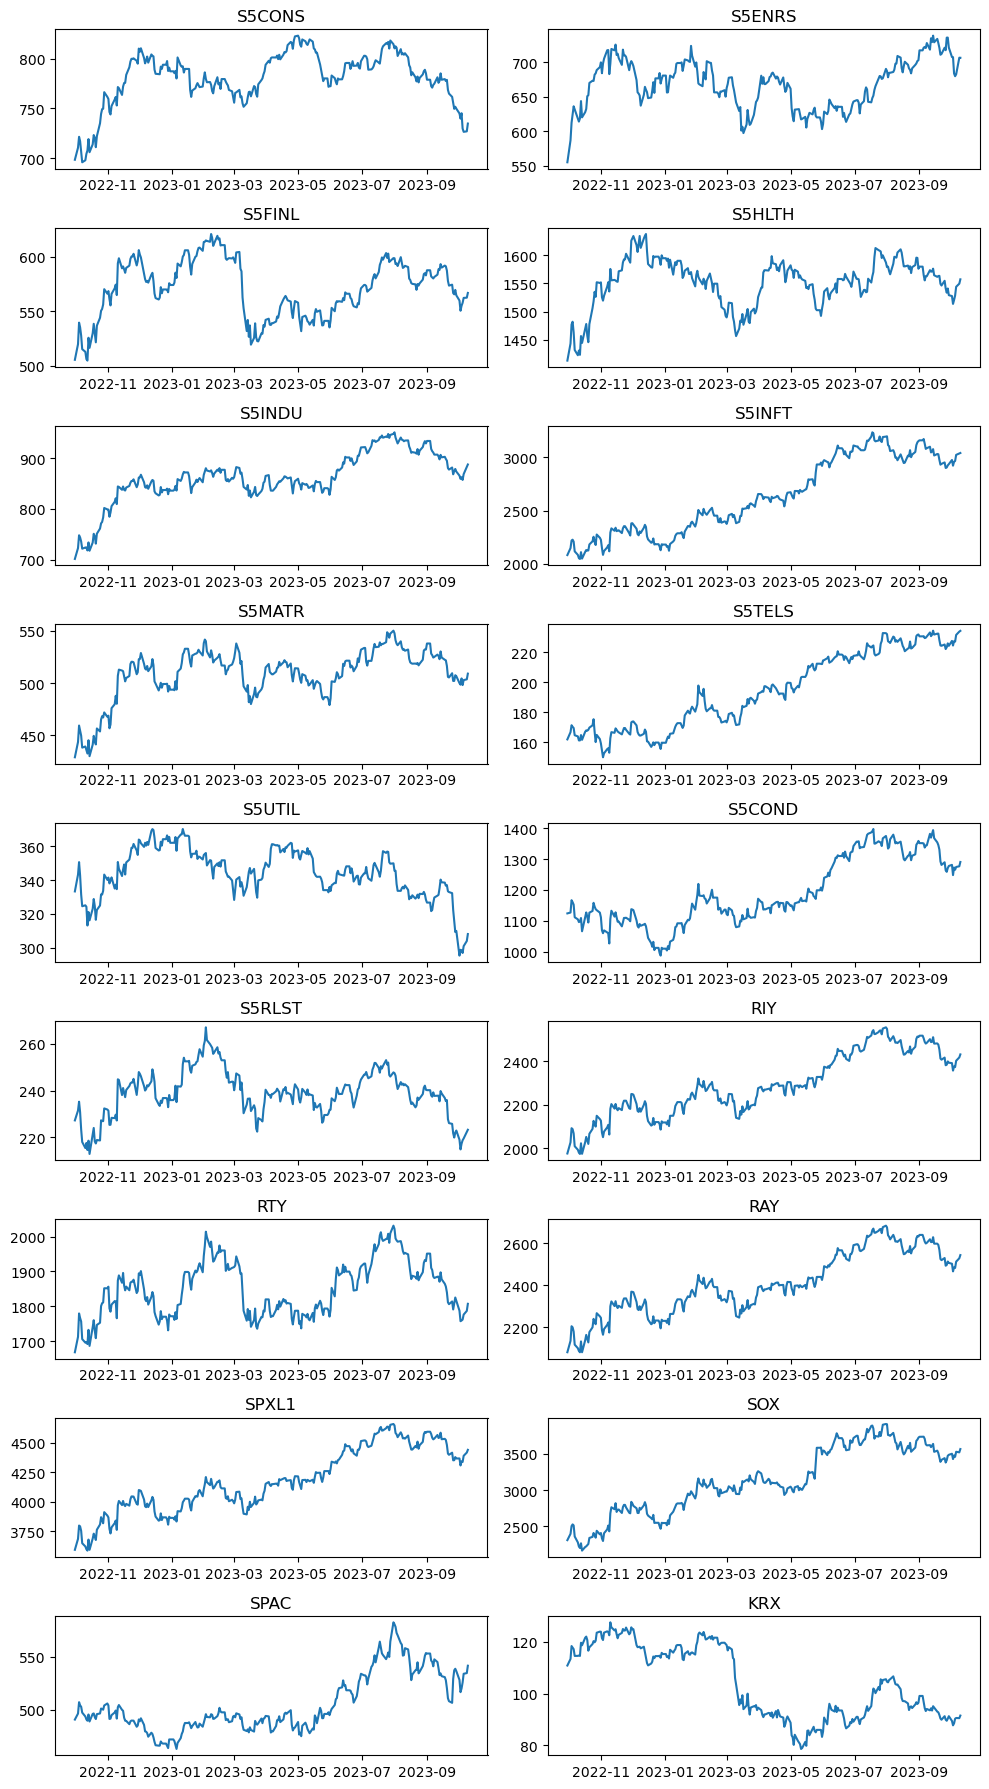

In [5]:
df = {
    'S5CONS': ['Cons_Staple'],
    'S5ENRS': ['Energy'],
    'S5FINL': ['Financials'],
    'S5HLTH': ['Health_Care'],
    'S5INDU': ['Industrials'],
    'S5INFT': ['Information'],
    'S5MATR': ['Materials'],
    'S5TELS': ['COMM_SVC'],
    'S5UTIL': ['Utilities'],
    'S5COND': ['Cons_Discret'],
    'S5RLST': ['Real_Estate'],
    'RIY': ['Russell_1000'],
    'RTY': ['Russell_2000'],
    'RAY': ['Russell_3000'],
    'SPXL1': ['Eco'],
    'SOX': ['SOX'],
    'SPAC': ['SPAC'],
    'KRX': ['ReginalBank']
}

html = f(df," index","tot_return_index_gross_dvds",html)

C:\Users\A1800401\AppData\Local\Temp\ipykernel_89736\1202258146.py:67: FutureWarning: this method is deprecated in favour of `Styler.to_html()`
  .render()


,Ticker,Name,1D,9/29,3/31
0,CL,WTI(Oil),-0.47%,-5.31%,14.05%
1,CO,BRENT(Oil),-0.57%,-4.93%,11.84%
2,XB,Gasolin,0.91%,-5.88%,3.20%
3,NG,NaturalGas,0.18%,15.47%,8.50%
4,KE,Coal(KEE),0.02%,-0.40%,-2.28%
5,TR,Coal(TRC),1.30%,-8.43%,14.98%
6,GC,Gold,0.59%,0.49%,-8.28%
7,SI,Silver,0.13%,-2.21%,-12.03%
8,PL,Platinum,0.16%,-2.81%,-12.13%
9,HG,Cooper,-0.33%,-2.77%,-12.36%


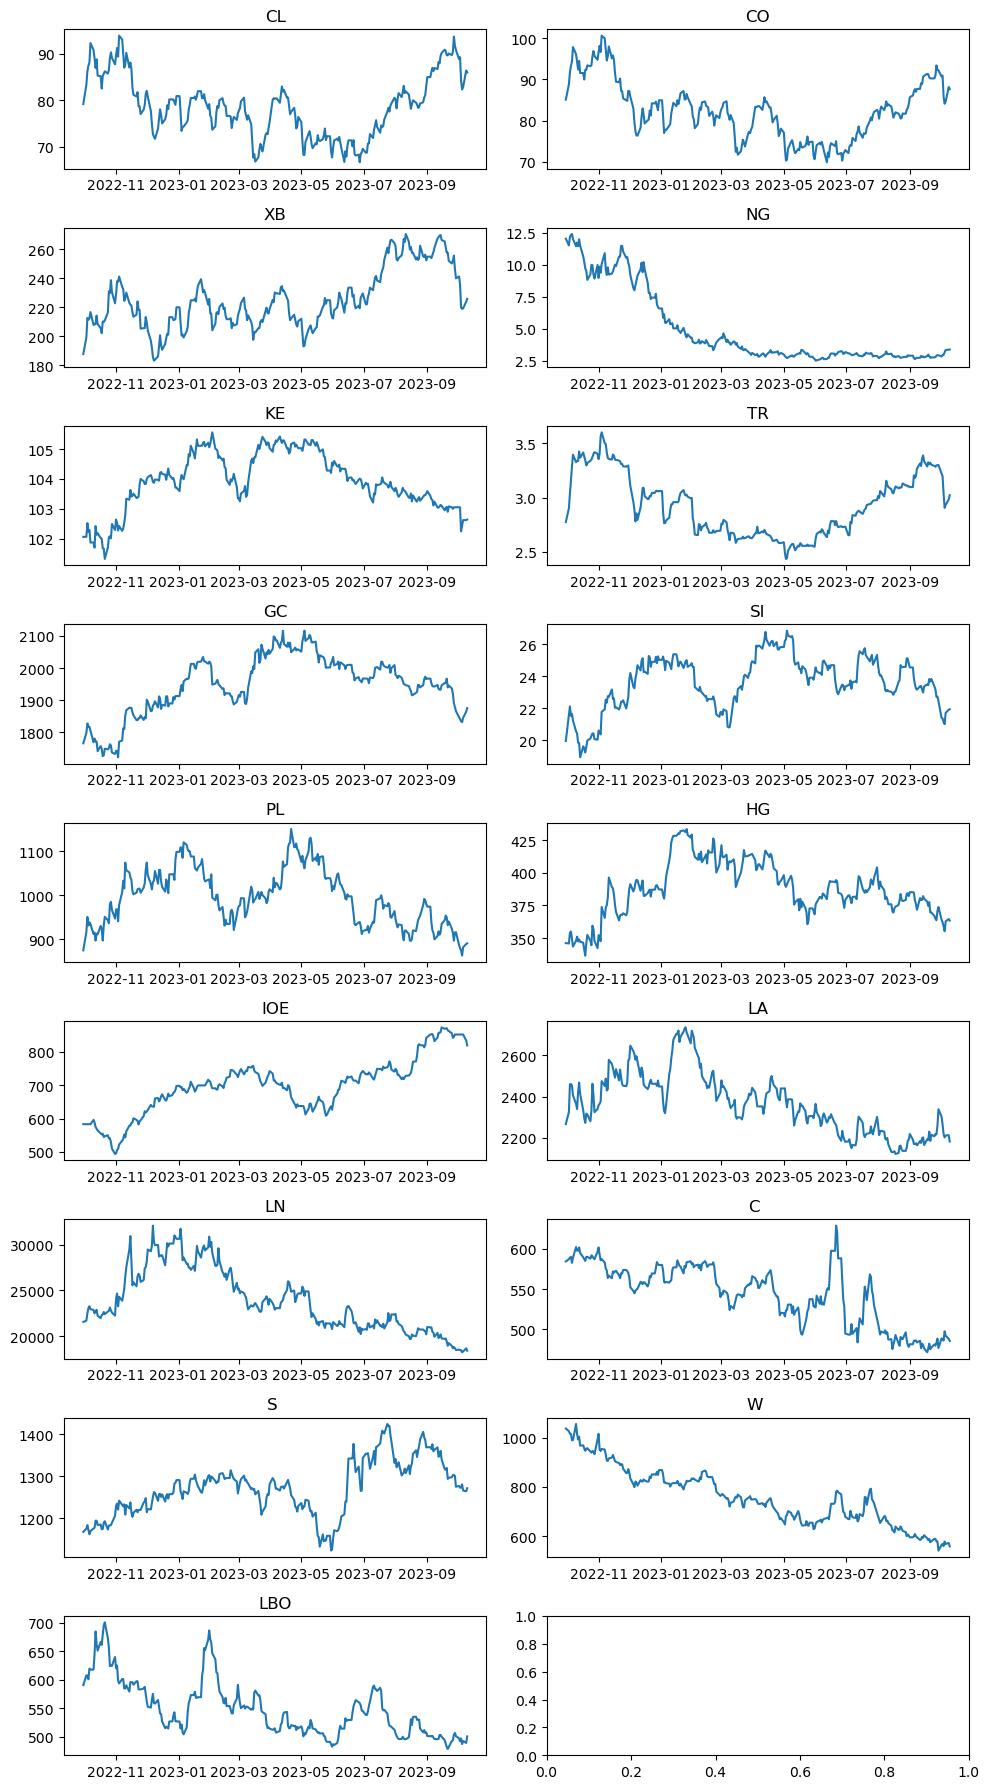

In [6]:
df = {
    'CL': ['WTI(Oil)'],
    'CO': ['BRENT(Oil)'],
    'XB': ['Gasolin'],
    'NG': ['NaturalGas'],
    'KE': ['Coal(KEE)'],
    'TR': ['Coal(TRC)'],
    'GC': ['Gold'],
    'SI': ['Silver'],
    'PL': ['Platinum'],
    'HG': ['Cooper'],
    'IOE': ['Iron'],
    'LA': ['Alum'],
    'LN': ['Nickel'],
    'C ': ['Corn'],
    'S ': ['Soybean'],
    'W ': ['Wheat'],
    'LBO': ['Lumber']
}

html = f(df,"1 Comdty","px_last",html)

In [7]:
df = {
    'TU': [''],
    '3Y': [''],
    'FV': [''],
    'TY': [''],
    'UXY': [''],
    'US': [''],
    'TWE': [''],
    'WN': [''],
    'DU': [''],
    'OE': [''],
    'RX': [''],
    'UB': [''],
    'OAT': [''],
    'IK': [''],
    'WB': [''],
    'G ': [''],
    'JB': [''],
    'TFS': [''],
    'TFC': [''],
    'TFT': ['']
}

html = f(df,"1 Comdty","px_last",html,2,1)

C:\Users\A1800401\AppData\Local\Temp\ipykernel_89736\1202258146.py:67: FutureWarning: this method is deprecated in favour of `Styler.to_html()`
  .render()


,Country,Ticker,Year,1D,9/29,3/31
0,US,TU,2.0,-0.07%,0.11%,-2.74%
1,,3Y,2.9,-0.12%,0.09%,-3.45%
2,,FV,4.4,-0.15%,-0.02%,-4.85%
3,,TY,6.9,-0.12%,-0.32%,-7.38%
4,,UXY,9.6,-0.08%,-0.66%,-9.75%
5,,US,17.3,0.03%,-1.51%,-14.88%
6,,TWE,19.3,1.50%,-1.88%,-15.51%
7,,WN,25.3,0.30%,-1.92%,-18.79%
8,DE,DU,1.9,-0.07%,0.21%,-0.99%
9,,OE,5.0,-0.11%,0.43%,-1.95%


In [8]:
df = {
    'GOVT US': [''],
    'AGG US': [''],
    'BND US': [''],
    'TIP US': [''],
    'SCHP US': ['']
}

html = f(df," Equity","tot_return_index_gross_dvds",html,0,1)

C:\Users\A1800401\AppData\Local\Temp\ipykernel_89736\1202258146.py:67: FutureWarning: this method is deprecated in favour of `Styler.to_html()`
  .render()


,Ticker,1D,9/29,3/31
0,GOVT US,-0.07%,-0.19%,-4.64%
1,AGG US,-0.10%,-0.17%,-4.29%
2,BND US,-0.10%,-0.25%,-4.26%
3,TIP US,0.04%,-0.36%,-4.46%
4,SCHP US,0.04%,-0.34%,-4.38%


C:\Users\A1800401\AppData\Local\Temp\ipykernel_89736\1202258146.py:62: FutureWarning: this method is deprecated in favour of `Styler.to_html()`
  .render()


,Ticker,1D,9/29,3/31
0,VIX,-0.67,-0.49,-1.67
1,VIX9D,-0.77,-0.09,0.60
2,VIX1D,-0.43,-2.60,-0.57
3,SKEW,1.53,0.67,9.32
4,MOVE,9.53,22.62,0.24


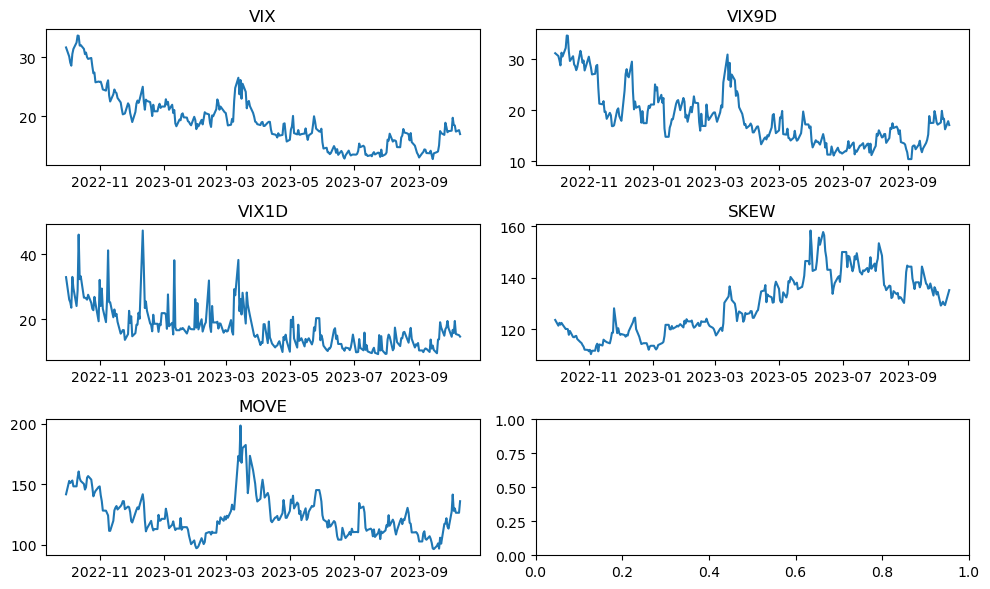

In [10]:
df = {
    'VIX': [''],
    'VIX9D': [''],
    'VIX1D': [''],
    'SKEW': [''],
    'MOVE': ['']
}

html = f(df," Index","px_last",html,0,0,1)

C:\Users\A1800401\AppData\Local\Temp\ipykernel_89736\1202258146.py:62: FutureWarning: this method is deprecated in favour of `Styler.to_html()`
  .render()


,Ticker,1D,9/29,3/31
0,CESIUSD,-1.50,11.70,-0.20
1,CESIEUR,1.10,14.70,-89.30
2,CESIJPY,-43.30,-5.80,-28.40


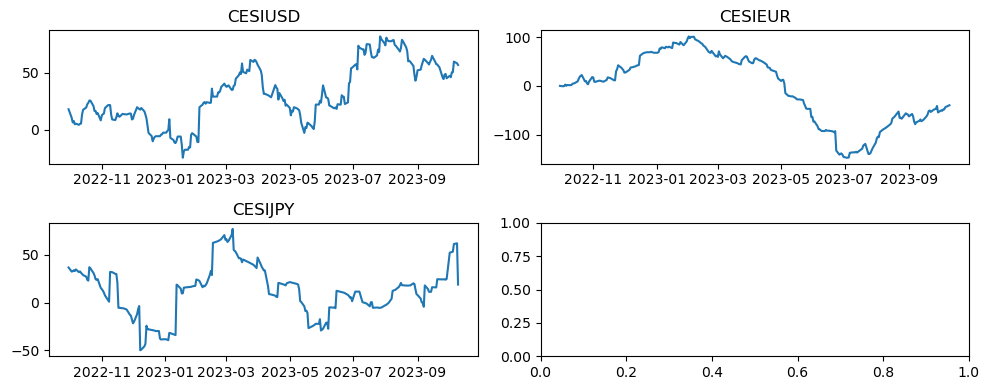

In [11]:
df = {
    'CESIUSD': [''],
    'CESIEUR': [''],
    'CESIJPY': ['']
}

html = f(df," Index","px_last",html,0,0,1)

C:\Users\A1800401\AppData\Local\Temp\ipykernel_89736\1202258146.py:62: FutureWarning: this method is deprecated in favour of `Styler.to_html()`
  .render()


,Ticker,1D,9/29,3/31
0,USDJPY25R1M,0.04,-0.05,0.79
1,USDJPY25R3M,0.00,0.02,0.74
2,EURUSD25R1M,0.08,-0.07,-0.15
3,EURJPY25R3M,0.04,0.06,0.76


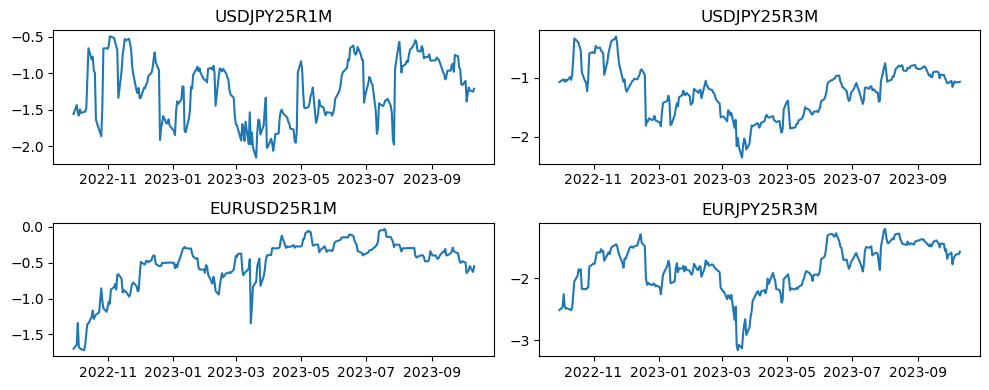

In [12]:
df = {
    'USDJPY25R1M': [''],
    'USDJPY25R3M': [''],
    'EURUSD25R1M': [''],
    'EURJPY25R3M': ['']
}

html = f(df," Index","px_last",html,0,0,1)

C:\Users\A1800401\AppData\Local\Temp\ipykernel_89736\1202258146.py:62: FutureWarning: this method is deprecated in favour of `Styler.to_html()`
  .render()


,Ticker,Name,1D,9/29,3/31
0,IBOXUMAE,CDS_IG,-0.81,0.66,-1.69
1,IBOXHYSE,CDS_HY,-7.64,4.42,20.84
2,ITRXEBE,CDS_Euro,-3.35,3.50,-1.48


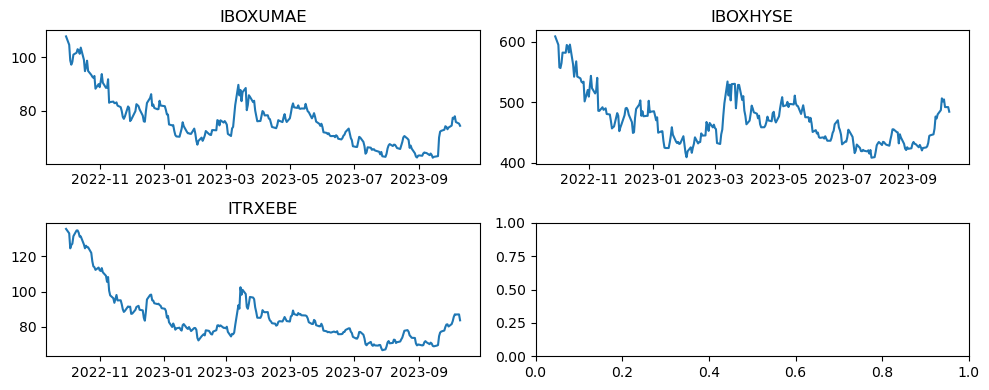

In [13]:
df = {
    'IBOXUMAE': ['CDS_IG'],
    'IBOXHYSE': ['CDS_HY'],
    'ITRXEBE': ['CDS_Euro']
}

html = f(df," CBGN Index","px_last",html,0,0,1)

In [14]:
tmp = "EQ_" + datetime.today().strftime('%Y%m%d') + ".html"
with open(tmp, "w") as f:
    f.write(html)
webbrowser.open('file://' + os.path.realpath(tmp))

True